# Tests of functions to determine what elements from the dicitonary to eliminate 

## Load dictionary & image

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from boostlets_mod import Boostlet_syst, indexs_max_conv_mask_dict, indexs_max_conv_mask_maskedDict, sk_to_phys
from mod_RIRIS_func import load_DB_ZEA, rand_downsamp_RIR, ImageOps, jitter_downsamp_RIR
from mod_plotting_utilities import plot_array_images



In [23]:
from mod_RIRIS_func import load_sk
# folder_dict = 'saved_dicts/tan_dicts'
# file_dict = 'BS_m_128_n_128_vsc_2_hsc_2_bases_0.5_0.5_thV_3_thH_7.mat'
folder_dict = 'ss_saved_dicts/'
file_dict = 'SS_m_128_n_128.mat'
Sk = load_sk(folder=folder_dict, file=file_dict, build_dict=None)


Loading dictionary
ss_saved_dicts/SS_m_128_n_128.mat


In [24]:
# Tamaño diccionario // Tamaño imagen interpolada
M, N  = 128, 128
# Imagen tamaño:
M0, N0 = 100, 100

# Image
room = "Balder"
ratio_mics = 0.5
extrap_mode = "extrapolate" # or pad

#  subimage 
Tstart = 1000
Tend = Tstart+M0



In [25]:
# ---------- LOAD Image ---------------------------
room = "Balder"
folder = "./dependencies/measurementData"
file = room+"RIR.mat"
file_path = os.path.join(folder, file)
print("Image loaded:")
print(file_path)

# Load full image and select a subimage to apply decomposition
full_image = load_DB_ZEA(file_path)[0]
orig_image = full_image[Tstart:Tend, :N0]
extr_size = Sk.shape[:2]


Image loaded:
./dependencies/measurementData\BalderRIR.mat


## Maintain all the elements of the dict that overlap with the vertical cone

In [26]:
fs = 11250
dx = 3e-2
dt = 1/fs
cs = 340

def rm_sk_index_in_horiz_cone(dx, dt, cs, Sk):
    """
    Input:
    dx = Distance between microphones
    dt = Temporal lag between samples
    cs = Speed of sound
    Sk = dictionary of [M,N] Fourier filters. Sk[M, N, P] where P is the number of filters in the dic
    
    Output:
    rm_sk_indxs: indexes of Sk that belong only to the horizontal cone K>OM that can be removed from Sk
                 for the acoustic reconstruction.
    """
    [M, N, P] = Sk.shape

    om = np.fft.fftshift( np.fft.fftfreq(n=M, d=dt) )
    kx = np.fft.fftshift( np.fft.fftfreq(n=N, d=dx) )
    k = cs * kx

    K, OM = np.meshgrid(k, om)
    vcone = np.abs(OM)>=np.abs(K) # vertical cone

    ls_maintain = []
    for i in range(P):  
        sk = Sk[:, :, i]
        proy = np.abs(sk) * vcone
        ls_maintain.append( np.sum(proy , axis=(0,1)) > 0 )

    ls_remove = [not b for b in ls_maintain] # list with True and False of elements to remove
    rm_sk_indxs = [i for i, val in enumerate(ls_remove) if val]  # Indexes of elements to remove 

    return rm_sk_indxs


rm_sk_indxs = rm_sk_index_in_horiz_cone(dx, dt, cs, Sk)
print('Indexes of elements to remove')
print(rm_sk_indxs)




Indexes of elements to remove
[2, 9, 18, 19, 20, 30]


# Differences between extrapolated and padded masks

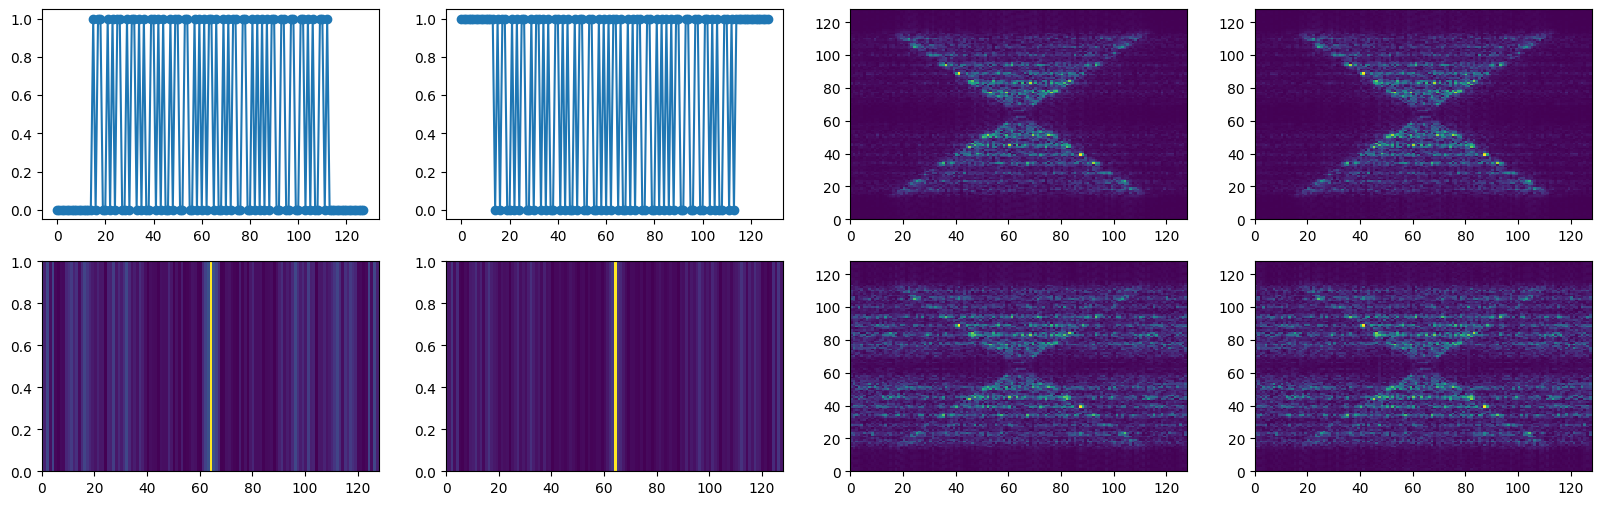

In [5]:
mask0, _ = jitter_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_mics)
imOps_p = ImageOps(orig_image.shape, mask=mask0, extrap_shape=extr_size, mode="pad") 
imOps_e = ImageOps(orig_image.shape, mask=mask0, extrap_shape=extr_size, mode="extrapolate")

image_p = imOps_p.expand_image(orig_image)
image_e = imOps_e.expand_image(orig_image)

mask_p = imOps_p.get_mask(image_p)
mask_e = imOps_e.get_mask(image_e)

F_Mp = np.fft.fftshift( np.fft.fft2(mask_p) )
F_Me = np.fft.fftshift( np.fft.fft2(mask_e) )
F_ImMp = np.fft.fftshift( np.fft.fft2(image_p*mask_p) )
F_ImMe = np.fft.fftshift( np.fft.fft2(image_e*mask_e) )
F_Imp = np.fft.fftshift( np.fft.fft2(image_p) )
F_Ime = np.fft.fftshift( np.fft.fft2(image_e) )


fig, ax = plt.subplots(2,4, figsize=(20,6))
ax[0,0].plot(np.arange(mask_p.shape[1]), mask_p[0,:], '-o')
ax[0,1].plot(np.arange(mask_e.shape[1]), mask_e[0,:], '-o')

ax[1,0].pcolor(np.abs(F_Mp))
ax[1,1].pcolor(np.abs(F_Me))

ax[0,2].pcolor(np.abs(F_Imp))
ax[0,3].pcolor(np.abs(F_Ime))
ax[1,2].pcolor(np.abs(F_ImMp))
ax[1,3].pcolor(np.abs(F_ImMe))


plt.show()


# Test of differences in spectrum of masked image with half of the microphones

In [6]:
mask0, _ = jitter_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_mics)
mask20, _ = jitter_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_mics/2)

imOps = ImageOps(orig_image.shape, mask=mask0, extrap_shape=extr_size, mode=extrap_mode) 
imOps2 = ImageOps(orig_image.shape, mask=mask20, extrap_shape=extr_size, mode=extrap_mode) 
image = imOps.expand_image(orig_image)

# Get mask for image & mask2 with 1/2 of the microphones which will create more masking noise in Fourier
mask = imOps.get_mask(image)
mask2 = imOps2.get_mask(image)

F_ImM1 = np.fft.fftshift( np.fft.fft2(image*mask) )
F_ImM2 = np.fft.fftshift( np.fft.fft2(image*mask2) )

# Filter Im spectrum with masking noise and 2*masking  noise
Sk2 = Sk*Sk
filtered_F_ImM1 = np.abs(F_ImM1[:,:,np.newaxis]) * Sk2
filtered_F_ImM2 = np.abs(F_ImM2[:,:,np.newaxis]) * Sk2

# scale the filtered regions
filtered_F_ImM1 /= np.max(filtered_F_ImM1)
filtered_F_ImM2 /= np.max(filtered_F_ImM2)

# Difference between filters (I expect it to be greater where there is no spectrum from the image, just from the masking noise)
diff_filters1 = np.mean( (filtered_F_ImM2 - filtered_F_ImM1), axis=(0,1) )
diff_filters2 = np.max( (filtered_F_ImM2 - filtered_F_ImM1), axis=(0,1) )
# List of ind to eliminate, those that areabove a threshold



In [7]:
# Esto fuera
extrap_mode='extrapolate'
mask0, _ = jitter_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_mics)
imOps = ImageOps(orig_image.shape, mask=mask0, extrap_shape=extr_size, mode=extrap_mode) 
image = imOps.expand_image(orig_image)
mask = imOps.get_mask(image)
m_image = image*mask # Masked image



# esto dentro de la funcion
mask2, _ = jitter_downsamp_RIR(Sk.shape[:2], ratio_t=1, ratio_x=ratio_mics/2) 

F_ImM1 = np.fft.fftshift( np.fft.fft2(m_image) )
F_ImM2 = np.fft.fftshift( np.fft.fft2(m_image*mask2) )

# Filter Im spectrum with masking noise and 2*masking  noise
Sk2 = Sk*Sk
filtered_F_ImM1 = np.abs(F_ImM1[:,:,np.newaxis]) * Sk2
filtered_F_ImM2 = np.abs(F_ImM2[:,:,np.newaxis]) * Sk2

# scale the filtered regions
filtered_F_ImM1 /= np.max(filtered_F_ImM1)
filtered_F_ImM2 /= np.max(filtered_F_ImM2)

# Difference between filters (I expect it to be greater where there is no spectrum from the image, just from the masking noise)
diff_filters1 = np.mean( (filtered_F_ImM2 - filtered_F_ImM1), axis=(0,1) )
diff_filters2 = np.max( (filtered_F_ImM2 - filtered_F_ImM1), axis=(0,1) )
# List of ind to eliminate, those that areabove a threshold


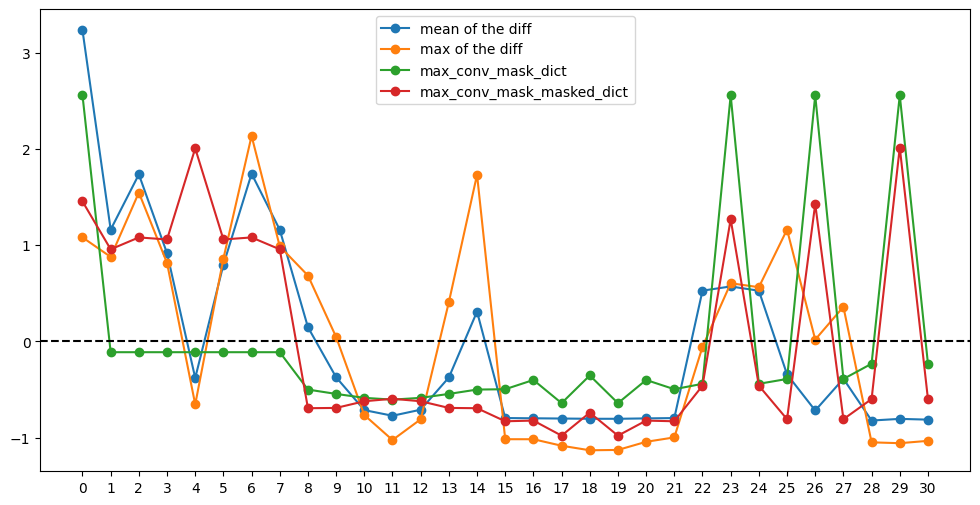

In [8]:
ind1, B1 = indexs_max_conv_mask_dict(mask=mask, Sk=Sk)
ind2, B2 = indexs_max_conv_mask_maskedDict(mask=mask, Sk=Sk)

ind = np.arange(len(diff_filters1))
z1 = stats.zscore(diff_filters1) # of the points excluding boostlet 0
z2 = stats.zscore(diff_filters2) # of the points excluding boostlet 0
z3 = stats.zscore(B1)
z4 = stats.zscore(B2)



fig, ax = plt.subplots(figsize=(12,6))
ax.plot(ind, z1, 'o-', label='mean of the diff')
ax.plot(ind, z2, 'o-', label='max of the diff')
ax.plot(ind, z3, 'o-', label='max_conv_mask_dict')
ax.plot(ind, z4, 'o-', label='max_conv_mask_masked_dict')

ax.axhline(0, color='black', linestyle='--')
ax.set_xticks(ind)
ax.legend()
plt.show()

It seems that I can try "max_of_the_diff" and "max_conv_mask_masked_dict". 
The first one focuses on zones where decreasing the microphones (more columns with zeros in the image and mask) increases a lot the spectrum (due to the mask). 
Since the spectrum related with the microphones should remain similar.
The second one focuses one those areas purely related with the mask that I can not capture with the previous method.

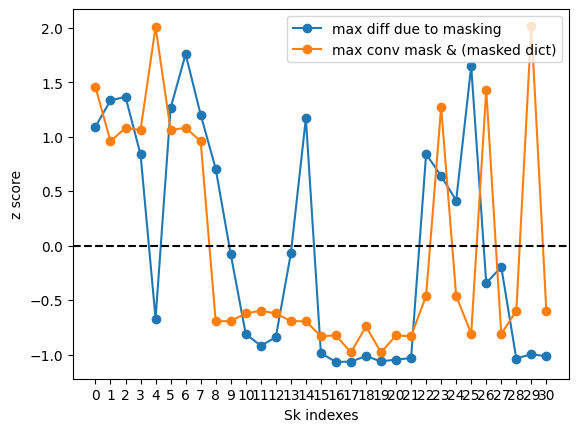

In [9]:



def sk_with_max_diff_spectrum_due2mask(ratio_mics, orig_image, Sk):
    """ 
    Inputs:
    ratio_mics: ratio of mics taken in the original mask (between 0 and 1)
    orig_image: image before padding [M0, N0]
    Sk: dictionary [M, N, n_elements]
    Outputs:
    ind: list of indexes of Sk to remove
    z2: zscore for each element in the dictionary of maxdiff( F_IM_mask - F_IM_mask2)
    """
    from mod_RIRIS_func import jitter_downsamp_RIR, ImageOps

    # Get masks for ratio of mics and half of that ratio
    mask0, _ = jitter_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_mics)
    mask20, _ = jitter_downsamp_RIR(orig_image.shape, ratio_t=1, ratio_x=ratio_mics/2)

    # Get the extrapolated/padded image
    imOps = ImageOps(orig_image.shape, mask=mask0, extrap_shape=Sk.shape[:2], mode='pad') 
    imOps2 = ImageOps(orig_image.shape, mask=mask20, extrap_shape=Sk.shape[:2], mode='pad') 
    image = imOps.expand_image(orig_image)

    # Get mask for image & mask2 with 1/2 of the microphones which will create more masking noise in Fourier
    mask = imOps.get_mask(image)
    mask2 = imOps2.get_mask(image)

    # Transform to Fourier the masked images
    F_ImM1 = np.fft.fftshift( np.fft.fft2(image*mask) )
    F_ImM2 = np.fft.fftshift( np.fft.fft2(image*mask2) )

    # Filter Im spectrum with masking noise and 2*masking  noise
    Sk2 = Sk*Sk # square of each dict (sum(Sk2)=1)
    filtered_F_ImM1 = np.abs(F_ImM1[:,:,np.newaxis]) * Sk2
    filtered_F_ImM2 = np.abs(F_ImM2[:,:,np.newaxis]) * Sk2

    # scale the filtered regions
    filtered_F_ImM1 /= np.max(filtered_F_ImM1)
    filtered_F_ImM2 /= np.max(filtered_F_ImM2)

    # Difference between filters (I expect it to be greater where there is no spectrum from the image, just from the masking noise)
    # diff_filters1 = np.mean( (filtered_F_ImM2 - filtered_F_ImM1), axis=(0,1) )
    diff_filters2 = np.max( (filtered_F_ImM2 - filtered_F_ImM1), axis=(0,1) )

    # List of ind to eliminate, those that are above a threshold
    z2 = stats.zscore(diff_filters2) 
    ind = np.where(z2>0)[0]
    ind = list(ind)
    
    # do not remove scaling function (remove 0 from this list)
    if 0 in ind:
        ind.remove(0)

    return ind, z2

def sk_ind2remove(ratio_mics, mask, orig_image, Sk, f_plot=False):
    """ 
    Inputs:
    ratio_mics: ratio of mics taken in the original mask (between 0 and 1)
    
    orig_image: image before padding [M0, N0]
    Sk: dictionary [M, N, n_elements]
    Outputs:
    ind: list of indexes of Sk to remove
    z2: zscore for each element in the dictionary of maxdiff( F_IM_mask - F_IM_mask2)
    """

    # mask0, _ = jitter_downsamp_RIR(Sk.shape[:2], ratio_t=1, ratio_x=ratio_mics)
    # mask20, _ = jitter_downsamp_RIR(Sk.shape[:2], ratio_t=1, ratio_x=ratio_mics/2)

    ind1, z1 = sk_with_max_diff_spectrum_due2mask(ratio_mics, orig_image, Sk)
    _, max_conv = indexs_max_conv_mask_maskedDict(mask=mask, Sk=Sk)
    z2 = stats.zscore(max_conv)
    ind2 = np.where(z2>0)[0]
    ind2 = list(ind2)

    if 0 in z2:
        ind2.remove(0)
    
    if f_plot:
        idx = np.arange(len(z1))
        fig, ax = plt.subplots()
        ax.plot(idx, z1, 'o-', label='max diff due to masking')
        ax.plot(idx, z2, 'o-', label='max conv mask & (masked dict)')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xticks(idx)
        ax.legend()
        ax.set_xlabel("Sk indexes")
        ax.set_ylabel("z score")
        plt.show()

    return (ind1 + ind2)


rm_sk_indxs = sk_ind2remove(ratio_mics, mask, orig_image, Sk, f_plot=True)





## Check superposition of dictionary and image

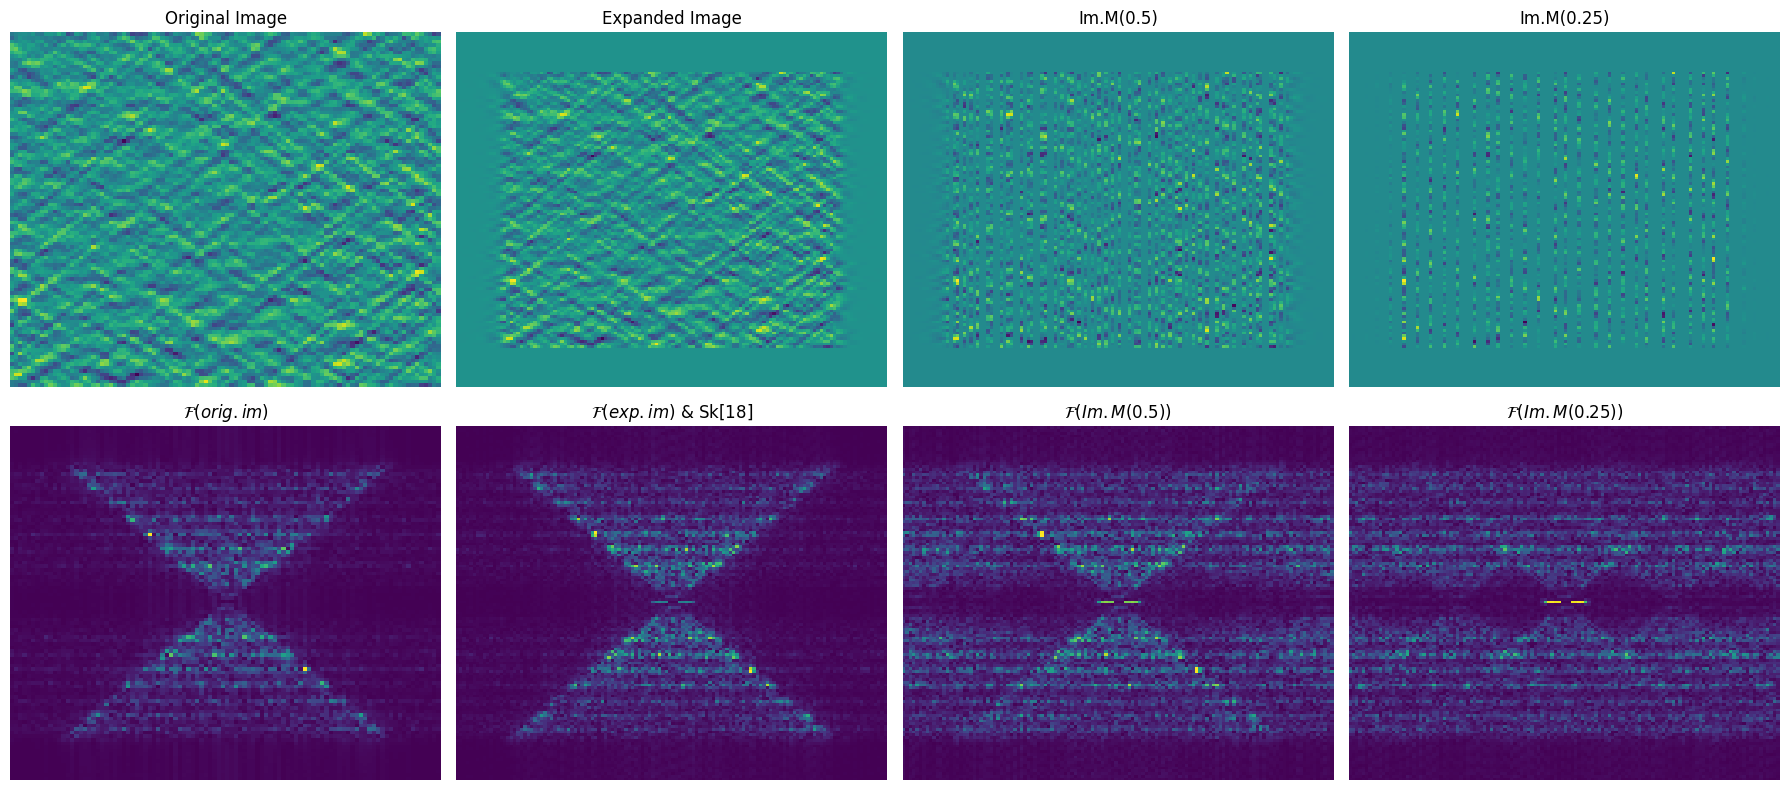

In [10]:

fft1 = np.fft.fftshift( np.fft.fft2(orig_image) )
fft2 = np.fft.fftshift( np.fft.fft2(image) )
fft3 = np.fft.fftshift( np.fft.fft2(mask*image) )
fft4 = np.fft.fftshift( np.fft.fft2(mask2*image) )

i = 18

images = [orig_image, image, mask*image, mask2*image, 
          abs(fft1), abs(fft2)+10*abs(Sk[:,:,i]), abs(fft3)+10*abs(Sk[:,:,i]), abs(fft4)+10*abs(Sk[:,:,i])]
titles = ['Original Image', 'Expanded Image', f'Im.M({ratio_mics})', f'Im.M({ratio_mics/2})', 
          r'$\mathcal{F}(orig. im)$', r'$\mathcal{F}(exp. im)$'f' & Sk[{i}]', r'$\mathcal{F}$'f'$(Im . M({ratio_mics}))$', r'$\mathcal{F}$'f'$(Im . M({ratio_mics/2}))$',
          ]

fig, axs = plt.subplots(2,4, figsize=(18, 8))
for ax, im, titl in zip(axs.flatten(), images, titles):
    ax.pcolor(im[:128,:])
    ax.set_title(titl)
    ax.axis('off')
plt.tight_layout()
plt.show()

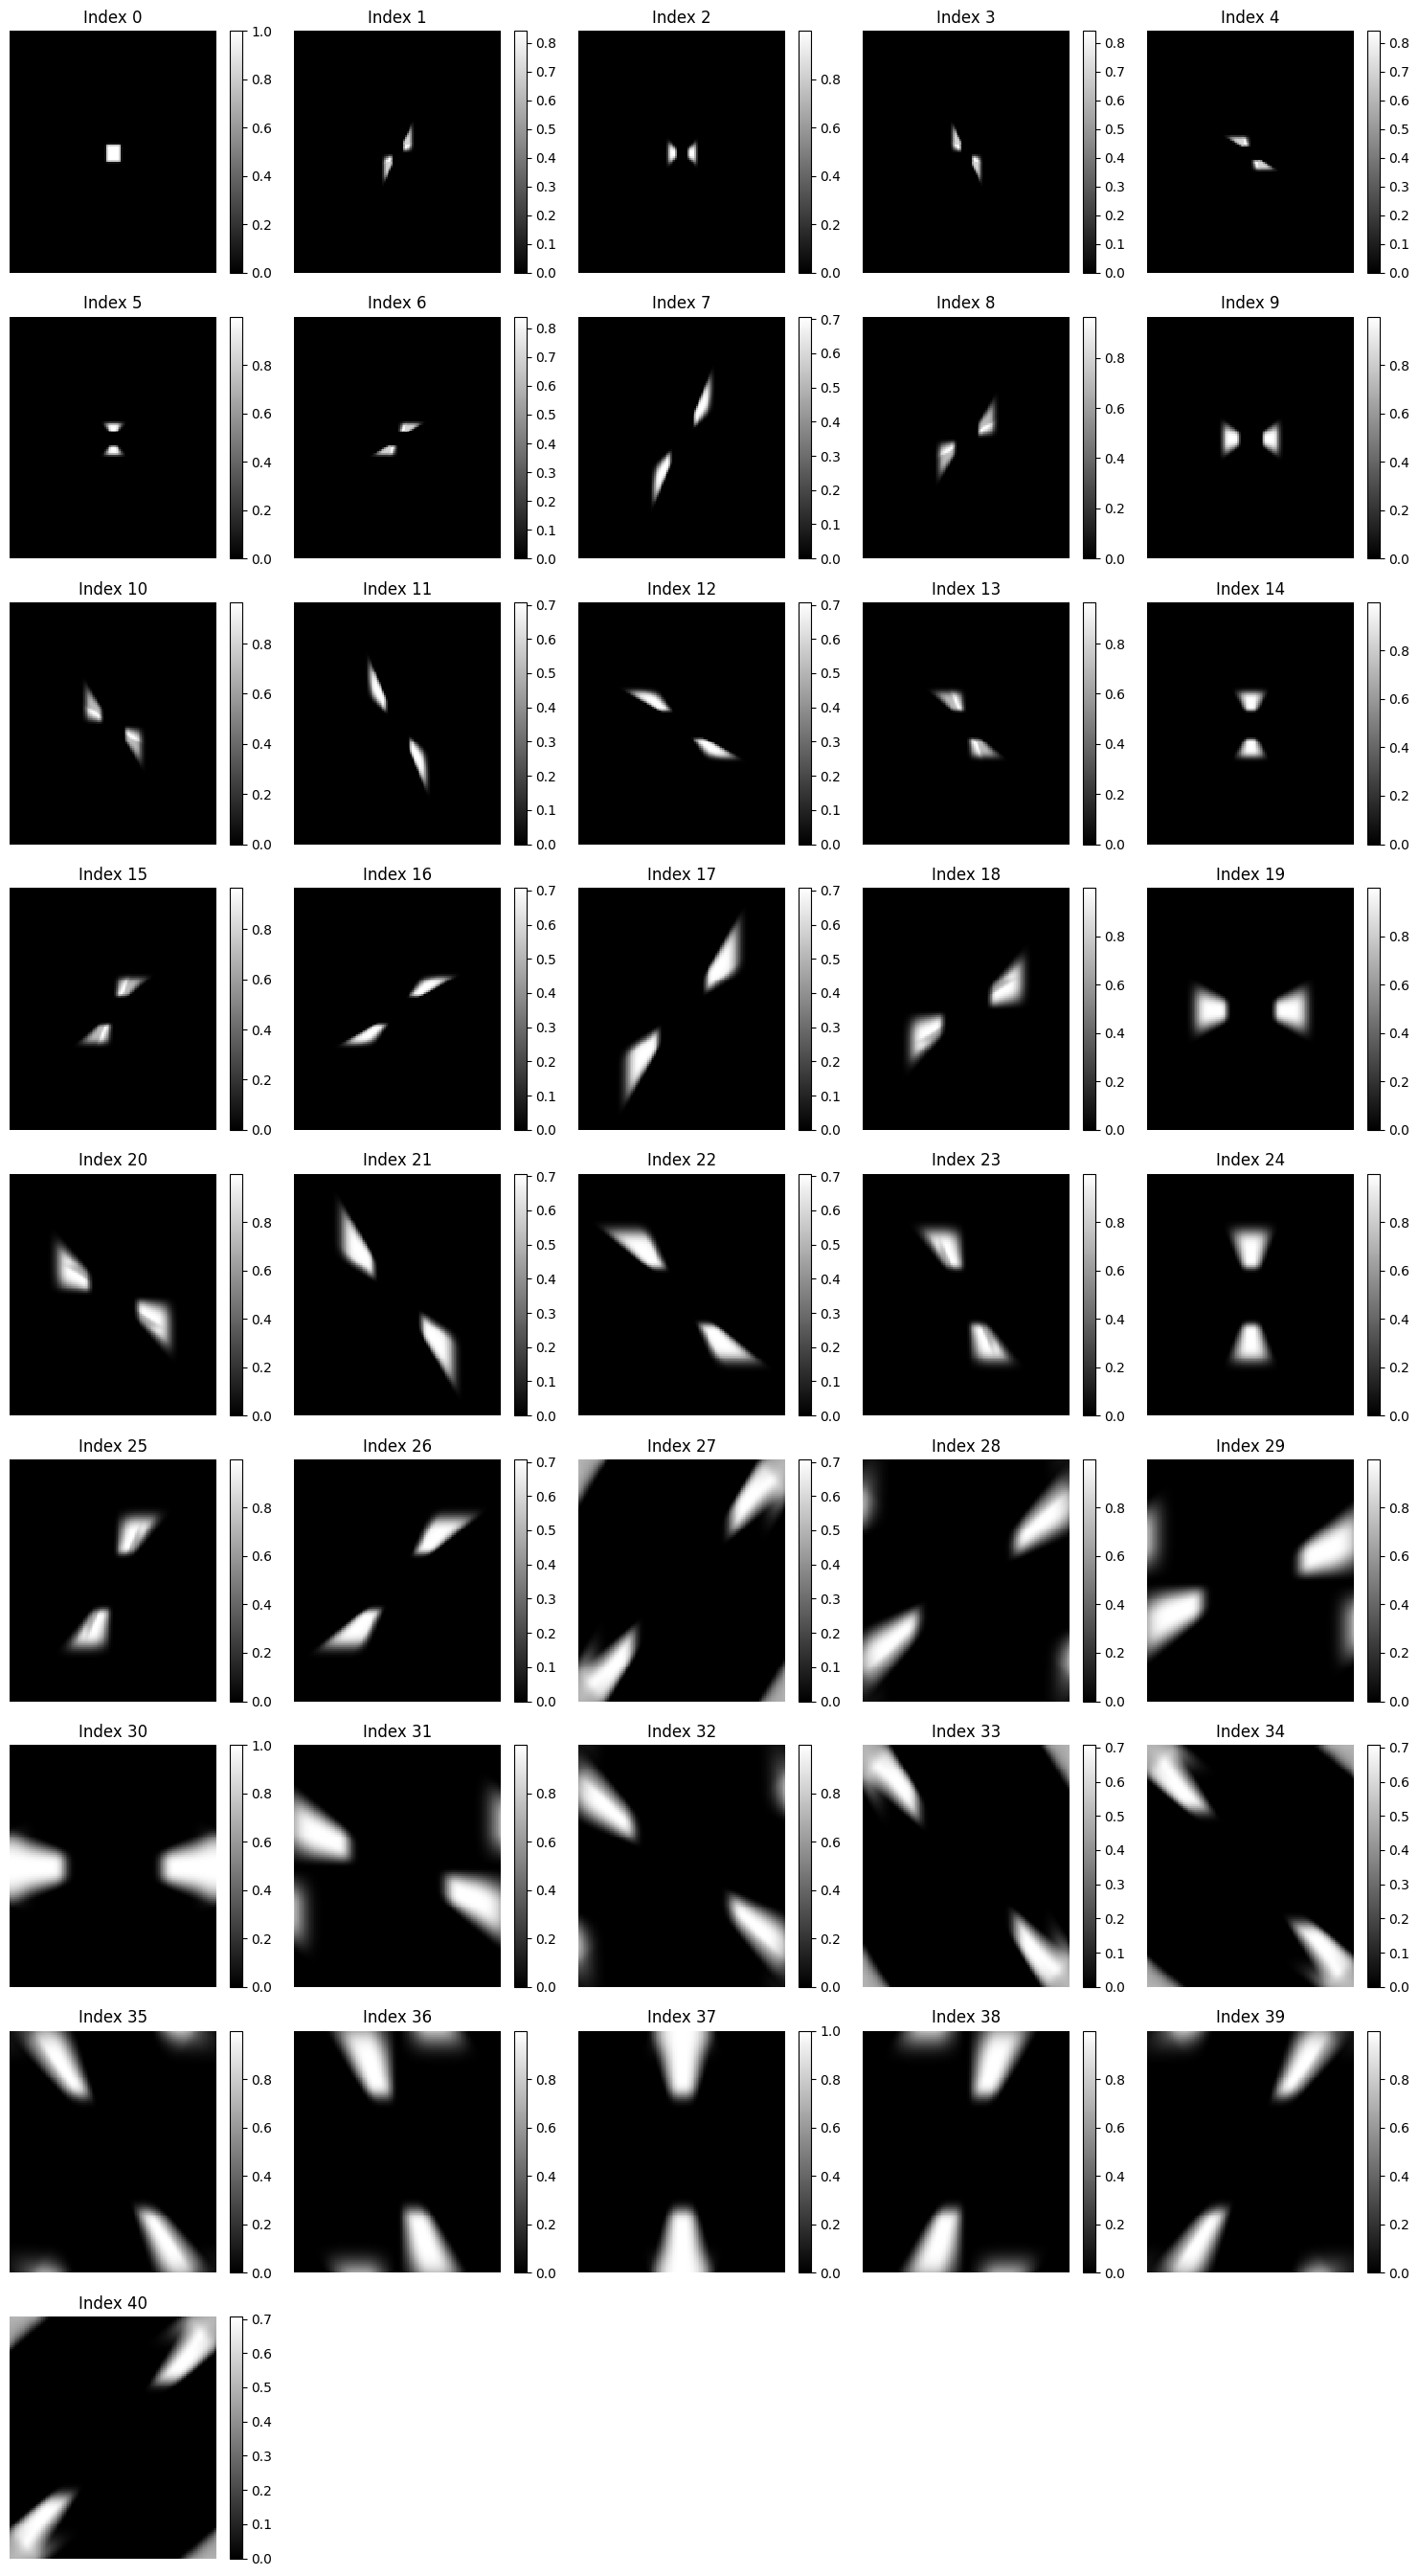

In [27]:
phys_sk = sk_to_phys(Sk)
# plot_array_images(phys_sk, cmap='gray', num_cols=5)
plot_array_images(Sk, cmap='gray', num_cols=5)

In [12]:
import scipy.io as sio

file_path = os.path.join(folder_dict, file_dict)

test = sio.loadmat(file_path)
print(test.keys())
print(test['label'])

import re
# Eliminar la extensión del archivo
name_without_extension = os.path.splitext(file_dict)[0]

# Usamos una expresión regular para extraer los números (incluyendo decimales)
numbers = re.findall(r'\d+\.?\d*', name_without_extension)

# Convertir a números flotantes o enteros según corresponda
numbers = [float(num) if '.' in num else int(num) for num in numbers]

print(numbers)


dict_keys(['__header__', '__version__', '__globals__', 'Psi', 'label'])
['boostlets with: \n2 vert. scales, 2 hor. scales, \n3 vert. angles, 7 hor. angles, \n\nfactor for supports: \nvert. base: 0.5, \nhor. base: 0.5']
[128, 128, 2, 2, 0.5, 0.5, 3, 7]
